In [5]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
with open('T1_1997a2000.csv') as CSVfile:
    readCSV = csv.reader(CSVfile, delimiter=",")
    dataI = np.transpose(list(readCSV))

with open('T1_2000a2005.csv') as CSVfile:
    readCSV = csv.reader(CSVfile, delimiter=",")
    dataII = np.transpose(list(readCSV))

with open('T1_2005a2010.csv') as CSVfile:
    readCSV = csv.reader(CSVfile, delimiter=",")
    dataIII = np.transpose(list(readCSV))

with open('T1_2010a2015.csv') as CSVfile:
    readCSV = csv.reader(CSVfile, delimiter=",")
    dataIV = np.transpose(list(readCSV))
    
with open('T1_2015a2018.csv') as CSVfile:
    readCSV = csv.reader(CSVfile, delimiter=",")
    dataV = np.transpose(list(readCSV))

In [7]:
data1 = dataI.copy()
data2 = dataII.copy()
data3 = dataIII.copy()
data4 = dataIV.copy()
data5 = dataV.copy()

In [8]:
def filter_outliers_destr(lst, minimum, maximum):
    while (np.min(lst) < minimum):
        error = np.argmin(lst)
        lst[error] = 0.5*(lst[error-1] + lst[error+1])
    while (np.max(lst) > maximum):
        error = np.argmax(lst)
        lst[error] = 0.5*(lst[error-1] + lst[error+1])

In [9]:
def filter_outliers_newlist(lst, minimum, maximum):
    new_lst = list(lst)
    
    while (np.min(new_lst) < minimum):
        error = np.argmin(new_lst)
        lst[error] = 0.5*(new_lst[error-1] + new_lst[error+1])
    while (np.max(new_lst) > maximum):
        error = np.argmax(new_lst)
        new_lst[error] = 0.5*(new_lst[error-1] + new_lst[error+1])
        
    return new_lst

In [10]:
def filter_spikes(data, min_roc, max_roc, toggle_nan=False):
    fil_indices = []
    old_values = []
    new_values = []
    
    lst = list(data)
    
    diff = np.diff(lst)
    i = 0
    while (i < len(diff)):
        if (diff[i] < min_roc):
            fil_indices.append(i+1)
            old_values.append(lst[i+1])
            drops = 1
            j = i + 1
            while (diff[j] == 0):
                fil_indices.append(j)
                old_values.append(lst[j])
                drops += 1
                j += 1
            if (toggle_nan):
                for k in range(i+1, j+1):
                    lst[k] = NaN
                    new_values.append(lst[k])
            else:
                slope = (0.5*(lst[j+1] - lst[i])) / drops
                for k in range(i+1, j+1):
                    lst[k] = lst[k-1] + slope
                    new_values.append(lst[k])
            i = j
        i += 1
    filtered = list(zip(fil_indices, old_values, new_values))
            
    return lst, filtered

In [11]:
## FOR Rate of Change errors ##

def find_velocity_extremes_individual(data, threshold):
    assert threshold > 0
    data = data.astype(np.float)
    extremes = []
    for i in range(2, len(data)-1):
        if not (np.isnan(np.array(data[i], dtype=np.float64)) or np.isnan(np.array(data[i+1], dtype=np.float64)) or np.isnan(np.array(data[i-1],dtype=np.float64))):
            diff1 = abs(data[i] - data[i-1])
            diff2 = abs(data[i+1] - data[i])
            if (diff1 > threshold and diff2 > threshold):
                extremes.append(i)
                extremes.append(i+1) 
    return extremes

def find_timestamp_ROC_errors(timestamps, data_header, extremes):
    error_timestamps = []
    for x in extremes:
        error_timestamps.append((timestamps[x], data_header))
    return error_timestamps

def replace_velocity_extremes_individual_NaN(data, threshold):
    extremes = find_velocity_extremes_individual(data, threshold)
    for x in extremes:
        data[x] = NaN

In [12]:
## FOR '-9999' to NaN drops ##

## Returns the number of '-9999' drops in one measurement.
def find_measurement_drops(measurement):
    return list(measurement).count("-9999")

## Returns the total number of '-9999' drops in a set of measurements.
def find_total_drops(all_data):
    drops = 0
    for measurement in all_data:
        drops += find_measurement_drops(measurement)
    return drops

## Prints the number of '-9999' drops in one measurement.
def print_measurement_drops(measurement):
    header = 0
    if (measurement[header] != " flag" and measurement[header] != "Timestamp"):
        print(measurement[header], ": ", find_measurement_drops(measurement))

## Prints the number of '-9999' drops in each measurement in a set of measurements.
def print_all_drops(all_data):
    header = 0
    for measurement in all_data:
            print_measurement_drops(measurement)
    print("TOTAL DROPS: ", find_total_drops(all_data), "\n")

## Filter and replace all '-9999' drops with 'NaN' values in one measurement.    
def replace_drops_NaN(measurement):
    measurment = measurement.tolist()
    for i in range(1, len(measurement)):
        if (measurement[i]== "-9999"):
            measurement[i] = NaN
    measurement = np.asarray(measurement)

## Filter and replace all '-9999' drops with 'NaN' values for all measurements
#  in a set of measurements.
def replace_alldrops_NaN(all_data):
    for measurement in all_data:
        if (measurement[0] != " flag" and measurement[0] != "Timestamp"):
            replace_drops_NaN(measurement)
            
## Return the indices of all drops in a measurement.
def find_dropindex(measurement):
    dropindices = []
    measurment = measurement.tolist()
    for i in range(1, len(measurement)):
        if (measurement[i] == "-9999"):
            dropindices.append(i)
    measurement = np.asarray(measurement)
    return dropindices

## Return the timestamps of drops in a specified measurement (string).
def find_timestamps_drops1(all_data, header):
    droplist = []
    headers = get_headers(all_data)
    if header in headers.keys():
        for x in find_dropindex(all_data[headers[header]]):
            droplist.append(all_data[0][x])
    return droplist        

## Return the timestamps of drops in a specified measurement (numerical index).
def find_timestamps_drops2(all_data, index):
    assert (index % 2 == 1) and (index > 0) and (index < len(all_data))
    droplist = []
    for x in find_dropindex(all_data[index]):
        droplist.append(all_data[0][x])
    return droplist

## Pair timestamps of every drop in a measurment with measurment header for every measurement.
#  If drops exceed the tolerance print out the number of drops instead.
def find_timestamps_drops_all(all_data, tolerance):
    droplist = []
    for measurement in all_data:
        if (measurement[0] != " flag" and measurement[0] != "Timestamp"):
            if (find_measurement_drops(measurement) < (tolerance*len(all_data[0]))):
                droplist.append((measurement[0], find_timestamps_drops1(all_data, measurement[0])))
            else:
                droplist.append((measurement[0], "", find_measurment_drops(measurment)), " drops")
    return dict(droplist)

# Print out the header, timestamp pairing for every measurement
def print_timestamps_drops_all(all_data, tolerance):
    droplist = find_timestamps_drops_all(all_data, tolerance)
    for x in droplist.keys():
        print(x, ": ", droplist[x])

# Return list of headers paired with indices in set.
def get_headers(all_data):
    headers = []
    for i in range(1, len(all_data)):
        headers.append((all_data[i][0], i))
    return dict(headers)

#######################################################################################################################

## FOR "-9999" drops to be interpolated ##

def interpolate_drops(measurement, dimensionality=0):
    measurement = measurement.tolist()
    if (dimensionality == 0):
        for i in range(2, len(measurement)):
            if (measurement[i] == "-9999"):
                j = 1
                while (measurement[i+j] == "-9999" and j < 6):
                    j+=1
                if (j == 6):
                    while(measurement[i+j] == "-9999"):
                        j+=1
                    measurement[i:j-1] = NaN
                    i += j+1
                else:
                    slope = (float(measurement[i+j]) - float(measurement[i-1])) / (j+1)
                    for k in range(i, i+j):
                        measurement[k] = float(measurement[k-1]) + slope
            else:
                i+=1
    return np.asarray(measurement)
                    
                
                
                    
                
            
                    


In [13]:
def find_VB(data):
    drops = []
    for i in range(1, len(data)):
        if (data[i] == "VB"):
            drops.append(i)
    print(len(drops))
    return drops

def replace(data, ind):
    for x in ind:
        data[x] = NaN
    return data

[]


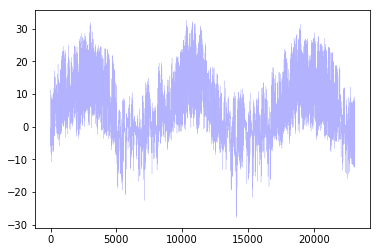

In [14]:
print(find_dropindex(data1[1]))
plt.plot(data1[1][1:], 'b', alpha=0.3, linewidth=0.3)

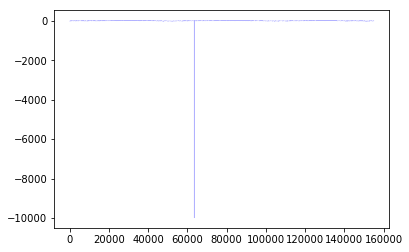

In [15]:
plt.plot(data5[1][1:], 'b', alpha=0.3, linewidth=0.3)

In [16]:
replace_alldrops_NaN(data1)
replace_alldrops_NaN(data2)
replace_alldrops_NaN(data3)
replace_alldrops_NaN(data4)
replace_alldrops_NaN(data5)

In [17]:
replace_velocity_extremes_individual_NaN(data1[1][1:], 10.0)
replace_velocity_extremes_individual_NaN(data2[1][1:], 5.0)
replace_velocity_extremes_individual_NaN(data3[1][1:], 5.0)
replace_velocity_extremes_individual_NaN(data4[1][1:], 5.0)
replace_velocity_extremes_individual_NaN(data5[1][1:], 5.0)

In [18]:
data1[1][1:] = replace(data1[1][1:], find_VB(data1[2]))
data2[1][1:] = replace(data2[1][1:], find_VB(data2[2]))
data3[1][1:] = replace(data3[1][1:], find_VB(data3[2]))
data4[1][1:] = replace(data4[1][1:], find_VB(data4[2]))
data5[1][1:] = replace(data5[1][1:], find_VB(data5[2]))

0
414
1498
2009
4


41910
-2.253
-4.613
-4.976
nan
['-44.34']


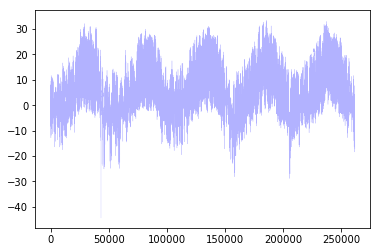

In [37]:
plt.plot(data4[1][1:], 'b', alpha=0.3, linewidth=0.3)
print(np.argmin(data4[1][1:].astype(float)))
#print(np.nanmin(data4[1][1:].astype(float)))
print(data4[1][41908])
print(data4[1][41909])
print(data4[1][41910])
print(data4[1][41921])
print([x for x in data4[1][1:] if float(x) < -30])

In [24]:
def reduce_and_mean(inp, size):
    data = inp[1:].astype(float)
    out = np.zeros(int((len(data))/size) + 1)
    i = 0
    while (i < len(data)):
        mean =  np.nanmean(data[i:(i+size-1)])
        out[int(i/size)] = mean
        i += size
    return out

def reduce_and_max(inp, size):
    data = inp[1:].astype(float)
    out = np.zeros(int((len(data))/size) + 1)
    i = 0
    while (i < len(data)):
        maxv =  np.nanmax(data[i:(i+size-1)])
        out[int(i/size)] = maxv
        i += size
    return out

def reduce_and_min(inp, size):
    data = inp[1:].astype(float)
    out = np.zeros(int((len(data))/size) + 1)
    i = 0
    while (i < len(data)):
        minv =  np.nanmin(data[i:(i+size-1)])
        out[int(i/size)] = minv
        i += size
    return out



In [89]:
data1_ref = reduce_and_mean(data1[1], 540)

data2a = reduce_and_mean(data2[1][:14617], 540)
data2b = reduce_and_mean(data2[1][14618:], 3240)
data2_ref = np.concatenate((data2a, data2b))

data3_ref = reduce_and_mean(data3[1], 3240)
data4_ref = reduce_and_mean(data4[1], 3240)
data5_ref = reduce_and_mean(data5[1], 3240)

data12345 = np.concatenate((data1_ref, data2_ref, data3_ref, data4_ref, data5_ref))


In [90]:
data1_max = reduce_and_max(data1[1], 540)

data2amax = reduce_and_max(data2[1][:14617], 540)
data2bmax = reduce_and_max(data2[1][14618:], 3240)
data2_max = np.concatenate((data2amax, data2bmax))

data3_max = reduce_and_max(data3[1], 3240)
data4_max = reduce_and_max(data4[1], 3240)
data5_max = reduce_and_max(data5[1], 3240)

data12345max = np.concatenate((data1_max, data2_max, data3_max, data4_max, data5_max))

In [91]:
data1_min = reduce_and_min(data1[1], 540)

data2amin = reduce_and_min(data2[1][:14617], 540)
data2bmin = reduce_and_min(data2[1][14618:], 3240)
data2_min = np.concatenate((data2amin, data2bmin))

data3_min = reduce_and_min(data3[1], 3240)
data4_min = reduce_and_min(data4[1], 3240)
data5_min = reduce_and_min(data5[1], 3240)

data12345min = np.concatenate((data1_min, data2_min, data3_min, data4_min, data5_min))

In [120]:
#DAILY AVG
data1_d = reduce_and_mean(data1[1], 24)

data2a = reduce_and_mean(data2[1][:14617], 24)
data2b = reduce_and_mean(data2[1][14618:], 144)
data2_d = np.concatenate((data2a, data2b))

data3_d = reduce_and_mean(data3[1], 144)
data4_d = reduce_and_mean(data4[1], 144)
data5_d = reduce_and_mean(data5[1], 144)

data12345d = np.concatenate((data1_d, data2_d, data3_d, data4_d, data5_d))
data12345d_30 = reduce_and_mean(data12345d, 30)
print(len(data12345d_30))

244


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [143]:
dates = []
i = 0
while (i < 244):
    month = (i - 3) % 12 + 1
    year = 1997 + int((i + 9)/12)
    inp = "" + str(month) + "/" + str(year)
    dates.append(inp)
    i+=1

In [144]:
datamaxmin = reduce_and_max(data12345min, 2)
datamean2 = reduce_and_mean(data12345, 8)
datamean2winter = datamean2[1::2]

In [154]:
xlab = [i for i in range(0,244)][::50]

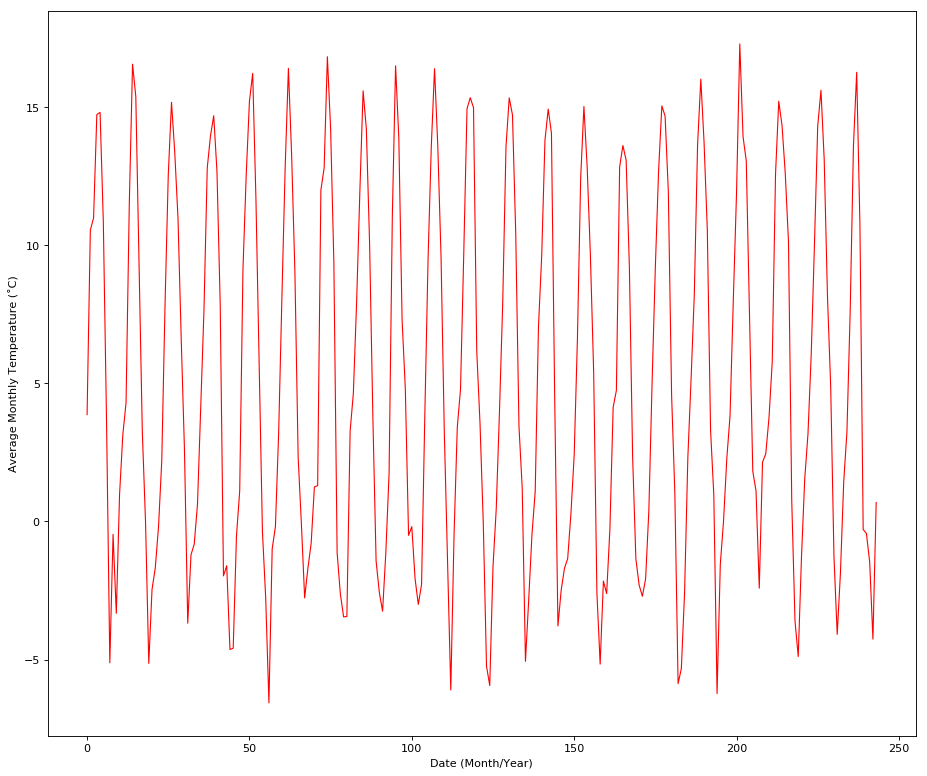

In [161]:
plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel("Date (Month/Year)")
plt.ylabel("Average Monthly Temperature (˚C)")
plt.plot(data12345d_30, 'r', alpha=1, linewidth=1)

#plt.plot(data12345max, 'b', alpha=1, linewidth=1)
#plt.plot(data12345min, 'g', alpha=1, linewidth=1)
#print(np.argmin(data12345min))
#plt.plot(datamaxmin, 'r', alpha=1, linewidth=1)
#plt.plot(datamean2winter, 'b', alpha=1, linewidth=1)


In [97]:
replace_velocity_extremes_individual_NaN(data5[1][1:], 10.0)

In [18]:
data[1] = interpolate_drops(data[1])
print(find_dropindex(data[1]))
print(data[1][63437])
print(data[1][63438])
print(data[1][63439])
print(data[1][63569])


NameError: name 'data' is not defined

In [12]:
clean_data = np.ndarray.copy(data)
replace_alldrops_NaN(clean_data)
print_all_drops(clean_data)

Air Temp Deg C Sagehen Creek Avg [Sagehen Creek] :  0
Air Temp Deg C Sagehen Creek Max [Sagehen Creek] :  0
Air Temp Deg C Sagehen Creek Min [Sagehen Creek] :  0
Barometric Pressure mbar Sagehen Creek Avg [Sagehen Creek] :  0
Battery Voltage volts Sagehen Creek Avg [Sagehen Creek] :  0
Battery Voltage volts Sagehen Creek Max [Sagehen Creek] :  0
Battery Voltage volts Sagehen Creek Min [Sagehen Creek] :  0
Misc Number 2 Unk Sagehen Creek [Sagehen Creek] :  0
Precipitation Geonor cm Sagehen Creek  [Sagehen Creek] :  0
Precipitation Geonor Freq Hz Sagehen Creek  [Sagehen Creek] :  0
Precipitation Geonor Freq Sagehen Creek Std [Sagehen Creek] :  0
Precipitation Geonor mm Sagehen Creek  [Sagehen Creek] :  0
Precipitation mm Sagehen Creek  [Sagehen Creek] :  0
Precipitation mm Sagehen Creek Cumulative [Sagehen Creek] :  0
Relative Humidity Per Sagehen Creek Avg [Sagehen Creek] :  0
Relative Humidity Per Sagehen Creek Max [Sagehen Creek] :  0
Relative Humidity Per Sagehen Creek Min [Sagehen C

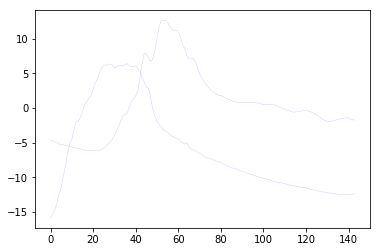

In [31]:
plt.plot(clean_data[1][195:339], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(clean_data[3][1:], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(clean_data[5][1:], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(clean_data[9][1:], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(clean_data[7][1:], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(clean_data[11][1:], 'b', alpha=0.3, linewidth=0.3)
#plt.plot(data[9][1:], 'b', alpha=0.3, linewidth=0.3)
plt.show()

In [ ]:
tempdiff = np.diff(clean_data[1][1:].astype(np.float))
print(min(tempdiff))
print(max(tempdiff))

In [ ]:
print_timestamps_drops_all(data, 0.05)